In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

### Command Line Reference:
When creating a project folder outside the Fast-AI repository, I create a symbolic link to the fast-ai library so that I can still use the repository:

`$ mklink /d fastai C:\users\<path-to-fastai>\fastai\fastai\`

In [4]:
# Pretty Printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Preparing and Preprocessing Data
---

In [5]:
PATH = Path('data/pascal')

with open(PATH/'pascal_train2007.json', 'r') as f:
    data = json.load(f)

In [6]:
printmd('**pascal_train json file:**')
for k in data.keys():
    print('+--',k, type(data[k]))
    if type(data[k]) == list:
        for m, i in data[k][0].items():
            print('   +--',m, type(i))
    else:
        print('    +--', data[k], type(data[k]))

**pascal_train json file:**

+-- images <class 'list'>
   +-- file_name <class 'str'>
   +-- height <class 'int'>
   +-- width <class 'int'>
   +-- id <class 'int'>
+-- type <class 'str'>
    +-- instances <class 'str'>
+-- annotations <class 'list'>
   +-- segmentation <class 'list'>
   +-- area <class 'int'>
   +-- iscrowd <class 'int'>
   +-- image_id <class 'int'>
   +-- bbox <class 'list'>
   +-- category_id <class 'int'>
   +-- id <class 'int'>
   +-- ignore <class 'int'>
+-- categories <class 'list'>
   +-- supercategory <class 'str'>
   +-- id <class 'int'>
   +-- name <class 'str'>


## Create key-pairs for IDs

In [7]:
category = {cat_dic['id']: cat_dic['name'] for cat_dic in data['categories']}
filename = {img_dic['id']: img_dic['file_name'] for img_dic in data['images']}
imageIDs = [img['id'] for img in data['images']]

## Get Image Paths

In [8]:
img_path = PATH/'VOCdevkit/VOC2007/JPEGImages'
print('file paths of a few images:')
list(img_path.iterdir())[:3]

file paths of a few images:


[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006948.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005796.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007006.jpg')]

## Create label dataset for images
The labels we want to predict (namely; the image label and the location of the object in the image) are tucked away in a json file. The Machine Learning framework I am using to train the model likes to have the data tabulated. Since I want to leverage the prebuilt training functions, I will do a bit of pre-processing of the data to get it in a machine learning friendly format. 

One aspect of this may be more of a personal taste, but it's the matter of having bounding box labels as *xy*, height, width instead of *x1, y1, x2, y2* coordinates. The following details some conversion functions that will be used while reformatting the labels

### Conversion Functions

In [9]:
def convert_bbox(bbox): 
    """
    convert bounding box from x, y, height width,
    to x1, y1 (top left) & x2, y2 (bottom right)
    """
    return np.array([bbox[1], 
                     bbox[0], 
                     bbox[3] + bbox[1] - 1, 
                     bbox[2] + bbox[0] - 1]) 

def revert_bbox(bbox):
    """
    revert bounding box back to original dimensions
    """
    return np.array([bbox[1], 
                 bbox[0], 
                 bbox[3] - bbox[1] + 1, 
                 bbox[2] - bbox[0] + 1])

### Display Conversion

In [61]:
annotation = data['annotations'][0]  
annotation # annotation information of first data point

{'area': 34104,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0,
 'image_id': 12,
 'iscrowd': 0,
 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}

In [88]:
bbox = annotation['bbox']
print('current box configuration:\n\t'
          'x (left):  {}\n\t'
          'y (lower): {}\n\t'
          'Width:     {}\n\t'
          'Height:    {}\n\t'.format(*bbox))
print('converted box configuration:\n\t'
          'y (lower): {}\n\t'
          'x (left):  {}\n\t'
          'y (top):   {}\n\t'
          'x (right): {}\n\t'.format(*convert_bbox(bbox)))

current box configuration:
	x (left):  155
	y (lower): 96
	Width:     196
	Height:    174
	
converted box configuration:
	y (lower): 96
	x (left):  155
	y (top):   269
	x (right): 350
	


### Create Label Dictionary from Annotations

In [95]:
labels = collections.defaultdict(lambda: [])
i = 0 
for img_ann in data['annotations']:
    if not img_ann['ignore']:
        imgID = img_ann['image_id']
        catID = img_ann['category_id']
        bbox = img_ann['bbox']
        bbox = convert_bbox(bbox)
        labels[imgID] += [(bbox, catID)]

In [97]:
printmd('**Testing Label Dictionary on Image ID 17:**')
(lambda l: [print('bbox:',x, 'label:', category[y]) for x, y in l])(labels[17]);

**Testing Label Dictionary on Image ID 17:**

bbox: [ 61 184 198 278] label: person
bbox: [ 77  89 335 402] label: horse


### Working with only the Largest Labeled Object 

For starters we're going to do recognition and detection on the largest object in the image. The dataset has multiple annotations per image (as seen above with Image 17), which may affect the ability of our model to predict the single largest image, but we can address that later.

In [54]:
# Create CSV of filenames and category label of largest object in image
def get_largest_object(imgID):
    """
    returns single image label of largest object in image.
    """
    global labels
    return sorted(labels[imgID], key=lambda x: np.product(x[0][-2:] - x[0][:2]), reverse=True)[0]

largest_object = {ID: get_largest_object(ID) for ID in imageIDs}

### Create Image Visualization Functions: Bounding Box, Labels and Images

In [98]:
def add_outline(obj, w):
    """
    Receives in an axis object and line width for the box, creates a patch.
    """
    obj.set_path_effects([patheffects.Stroke(linewidth=w, foreground='black'),
                          patheffects.Normal()])
    
def annotate_img(ax, data):
    bbox, ID = data
    bbox = revert_bbox(bbox)
    patch = patches.Rectangle(bbox[:2], *bbox[-2:], 
                              fill=False, edgecolor='white', lw=2)
    
    box = ax.add_patch(patch)
    txt = ax.text(*bbox[:2],s=category[ID],  
                  verticalalignment='top',
                  color='white',
                  fontsize=14,
                  weight='bold')
    
    add_outline(box, 4)
    add_outline(txt, 1)

    
def display_img(img, label_data, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    
    annotate_img(ax, label_data)
    
    return ax

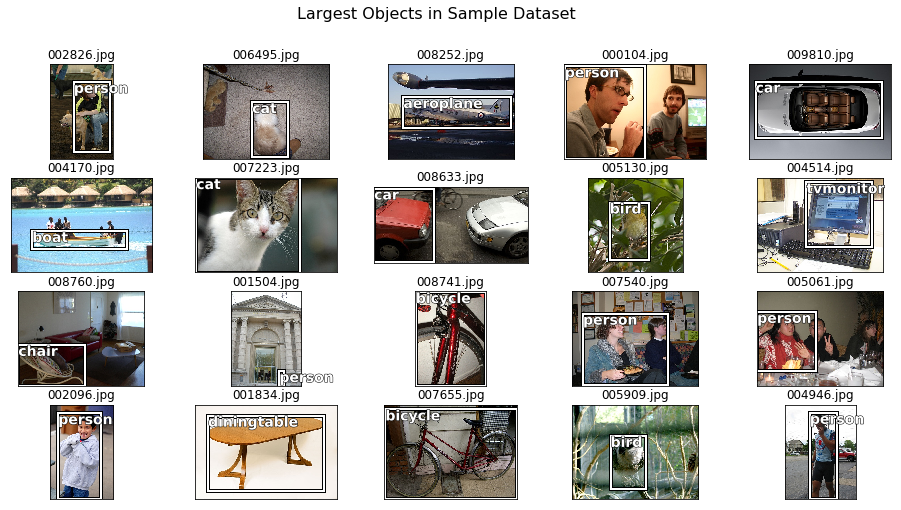

In [130]:
fig, axs = plt.subplots(4, 5, figsize=(16,8))
fig.suptitle('Largest Objects in Sample Dataset', size=16)
axs = axs.flatten()
for ax in axs:
    # Pick a random image
    imID = np.random.choice(imageIDs)
    
    file = filename[imID]
    ax.set_title(str(file))
    
    im = open_image(img_path/file)
    
    label_data = largest_object[imID]
    display_img(im, label_data, ax=ax)

## Preprocess data labels 
The labels we want to use to train the model are kept in a json file. I will unpack this and re-organize it into a CSV for batch loading during the training procedure. 

In [15]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/largest-labels.csv'
CSV_BB = PATH/'tmp/largest-bbox.csv'

In [16]:
# Create CSV of data
import pandas as pd

d1 = pd.DataFrame(
    {
    'file':     [filename[ID] for ID in imageIDs], 
    'category': [largest_object[ID][1] for ID in imageIDs]
    }, 
    columns=['file', 'category'])

d2 = pd.DataFrame(
    {
    'file': [filename[ID] for ID in imageIDs], 
    'bbox': [' '.join([str(i) for i in largest_object[ID][0]]) for ID in imageIDs]
    }, 
    columns=['file', 'bbox'])

d1.to_csv(CSV, index=False)
d2.to_csv(CSV_BB, index=False)

printmd('**Top rows from training label CSV file**')
d2.merge(d1, on=['file']).head()

**Top rows from training label CSV file**

,file,bbox,category
0,000012.jpg,96 155 269 350,7
1,000017.jpg,77 89 335 402,13
2,000023.jpg,1 2 461 242,15
3,000026.jpg,124 89 211 336,7
4,000032.jpg,77 103 182 374,1


## Prepare Data with Augmentation

Deep Learning models are very prone to overfitting. The numerous layers lead to an enormous amount of parameters that tune themselves to map inputs to outputs, and the high dimensionality of these deep models can easily lead to poor generalization on unseen data. The best way to fight overfitting is to get more data: a larger distribution of samples that represent the chosen ground truth labels. If you don't have access to more samples, the second best way is to aritifically make some. Maybe a cat is a cat whether it's red or grey or white? If you just have a white picture of a cat, maybe make a couple samples of different colors. If a cat is looking left, it's still a cat if it looks right, so maybe flip the image. 

To increase the robustness of the model we're traingin here, we will inforporate a lot of augmentation tactics to each image. sample images are rotated slightly, flipped and get some lighting adjusments. 

One implementation detail: When an image is translated or rotated, the bounding box labels need to also be adjusted in the same way so the bounding box ground truth still overlaps the objects. 

We'll start by augmenting the image data and transforming the bounding boxes to match, then we'll grab the label data and join it with the transformed bounding box data to get a single dataset of samples and labels.

In [142]:
size = 224
batch_size = 64
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

# y labels are coordinates, make sure transorm adjusts dependent variable (y) as well
augmenter = [RandomFlip(tfm_y=TfmType.COORD), 
             RandomRotate(30, tfm_y=TfmType.COORD), 
             RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD)]

transform = tfms_from_model(base_model, size, aug_tfms=augmenter, tfm_y=TfmType.COORD, crop_type=CropType.NO)

bbox_data = ImageClassifierData.from_csv(PATH, JPEGS, CSV_BB, tfms=transform, bs=batch_size)
lbls_data = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(base_model, size), bs=batch_size)

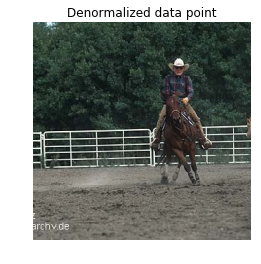

In [20]:
x, y = next(iter(lbls_data.trn_dl))
img  = lbls_data.val_ds.denorm(to_np(x))[0]

fig, ax = plt.subplots()
ax.imshow(img)
_ = plt.axis('off')
_ = plt.title('Denormalized data point')

In [21]:
torch.cuda.device(0)

## Creating a CNN Model for Image Recognition
---
The first part of this Object Detection journey is to build a model to at least recognize objects in the image. This is a classification task, so we're going to take a pre-trained base model from the ResNet34 architecture, inherit the optimized weights and learn a new objective with the dataset we're working with.

In [22]:
base_model = resnet34

In [23]:
# Create a trainer
# md      = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=transform, bs=batch_size)
trainer = ConvLearner.pretrained(base_model, lbls_data, metrics=[accuracy])
trainer.opt_fn = optim.Adam

In [25]:
trainer.lr_find(1e-5, 100)

 81%|████████▏ | 26/32 [00:05<00:01,  5.07it/s, loss=27.8]


#### Training Loss Recorded at each Increase of Learning Rate

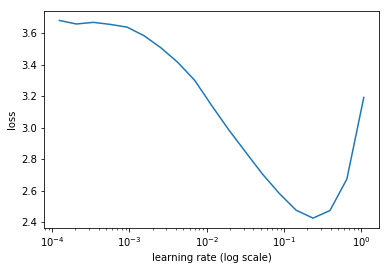

In [29]:
printmd("#### Training Loss Recorded at each Increase of Learning Rate")
trainer.sched.plot(n_skip=5, n_skip_end=1)

### Observations
What this graph indicates is a callback routine that increases the learning rate at each batched iteration of training. At the start of training, the learning rate is too low to see any considerable decrease in predictive error of the model. As the learning rate increases, the loss begins to decrease at a faster rate (hence the change in slope). There comes a point in the learning rate setting where the loss no longer decreases, and instead begins to increase, which means the learning rate is too high and the large gradient update is causing the weights of the model to bounce around instead of descending towards a minima. We want to select a learning rate before this happens; ideally where the slope of loss is the steepest. 

### Setting the Learning Rate

In [30]:
lr = 2e-2

## Evaluate Pre-trained model

In [31]:
trainer.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.249397   0.577103   0.812     



[array([ 0.5771]), 0.81199999761581421]

## Observations
Out of the box, the model performs very well on Object detection. To put an accuracy of 81.2% in perspective; a random guess would be correct 10% of the time if there were 10 classes to guess on. Needless to say, random guessing is economically useful for probably most tasks, so better than random may still be useless depending on the task. Let's keep optimizing the model.

### Setup a Learning Rate Scheduler
Different sections of a deep learning model have weights of different magnitude that are more sensitive to gradients. Generally it's good practice to tweak the weights closer to the input image less than top layer weights. What is a reasonable step to make for one layer may be way too big for the other.

**A good inituition on learning rates is that the gradient step (Learning rate * raw gradient) should be 0.1% of the actual weights.**

The library allows for setting different learning rates that can apply to different areas of the model, so we'll set the learning rate for initial layers a few orders of magnitiude smaller than the later layers.

In [37]:
lr_sched = np.array([lr/1000, lr/100, lr])

In [38]:
trainer.freeze_to(-2)
trainer.fit(lr_sched, n_cycle=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.271463   0.947846   0.754     



[array([ 0.94785]), 0.75400000143051149]

## Observations
The model actually decreased in accuracy! This might mean the learning rate was set too high.

### Freeze up to last two layers, train the last two layers

## Determine appropriate learning rate

 81%|████████▏ | 26/32 [00:07<00:01,  3.39it/s, loss=2.28]


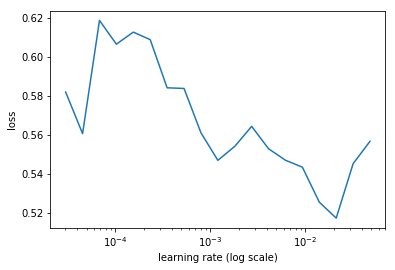

In [39]:
printmd('## Determine appropriate learning rate')
lr_finder = trainer.lr_find(lr_sched/1000)
trainer.sched.plot(1)

## Observations
Perhaps the learning rate should be be reduced slightly. 1e-2 seems too high

### Train for another epoch

In [40]:
trainer.fit(lr_sched/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.471289   0.576805   0.826     



[array([ 0.57681]), 0.82599999761581422]

### Unfreeze all layers, continue training

In [42]:
trainer.unfreeze()
trainer.fit(lr_sched/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.211594   0.593009   0.838     
    1      0.154456   0.586642   0.834     



[array([ 0.58664]), 0.83399999952316284]

### Run a prediction
The model is trained with somewhat reasonable accuracy. The challenge here is trying to predict what the largest item is in the sample dataset when the sample dataset includes smaller objects in the same image. We're going to take the model with the accuracy as is and run some predictions.

In [45]:
x, y = next(iter(lbls_data.val_dl))
prob = F.softmax(predict_batch(trainer.model, x), -1)
x, preds = to_np(x), to_np(prob)
preds = np.argmax(preds, -1)

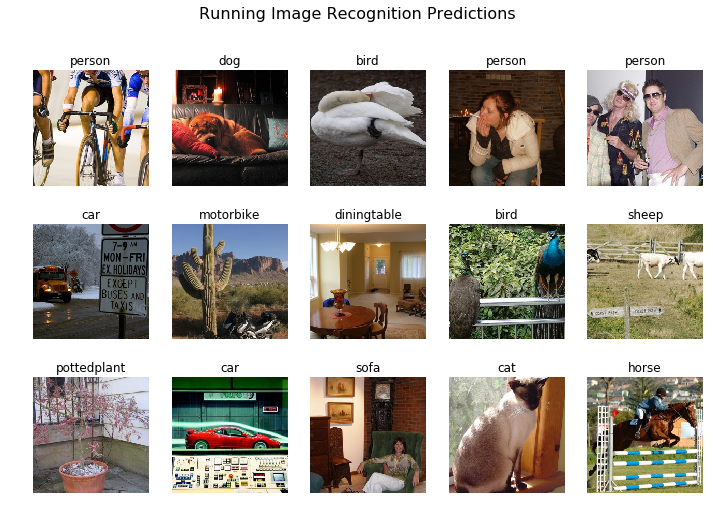

In [117]:
fig, axes = plt.subplots(3,5, figsize=(12,8))
fig.suptitle('Running Image Recognition Predictions', size=16)
for i, ax in enumerate(axes.flat):
    image = lbls_data.val_ds.denorm(x)[i]
    label = lbls_data.classes[preds[i]]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(category[int(label)])
    

In [129]:
printmd('**First five rows of bounding box label CSV file**')
with open(CSV_BB, 'r') as f:
    for l in f.readlines()[:5]:
        print(l.replace(',', ('\t\t' if l[0] =='f' else '\t')))

**First five rows of bounding box label CSV file**

file		bbox

000012.jpg	96 155 269 350

000017.jpg	77 89 335 402

000023.jpg	1 2 461 242

000026.jpg	124 89 211 336



## Creating a CNN Model for Object Detection
---

In [131]:
f_model=resnet34
sz=224
bs=64

In [132]:
augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

[ 0.  0. -1. -1.]
[ 0.  0. -1. -1.]
[ 0.  0. -1. -1.]
[ 0.  0. -1. -1.]
[ 0.  0. -1. -1.]
[ 0.  0. -1. -1.]


KeyboardInterrupt: 

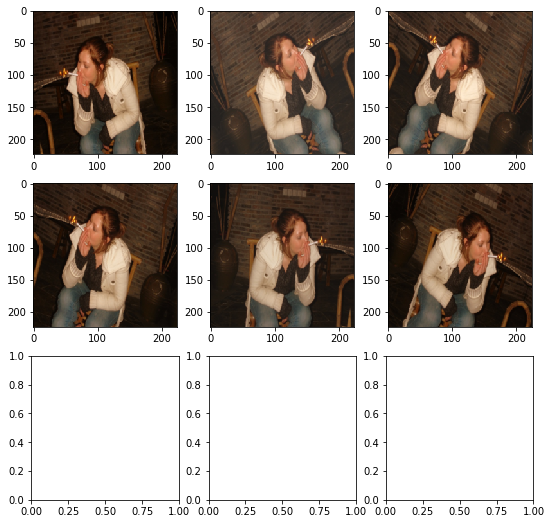

In [146]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))

for i,ax in enumerate(axes.flat):
    x,y = next(iter(bbox_data.aug_dl))
    ima = bbox_data.val_ds.denorm(to_np(x))[idx]
    b = convert_bbox(to_np(y[idx]))
    print(b)
    ax.imshow(ima)

### Combine Bounding Box and Labels to One Dataset

In [ ]:
# Custom PyTorch dataset
class ConcatLblDataset(Dataset):
    
    def __init__(self, init_data, more_data):
        self.init_data = init_data
        self.more_data = more_data
        
    def __len__(self):
        return len(self.init_data)
    
    def __item__(self, i):
        x, y = self._init_data[i]
        return (x, (y, self.more_data[i]))
    
# Concatenate the labels to one dataset
train = ConcatLblDataset(bbox_data.trn_ds, lbls_data.trn_y)
valid = ConcatLblDataset(bbox_data.val_ds, lbls_data.trn_y)

# # Replace the data loaders of the original datasets with the concatenated datasts
# bbox_data.trn_dl.dataset = train
# bbox_data.val_dl.dataset = valid